## Lab -- March 29th 30th

This lab is based off the *Dynamic.plots.1/2/3.ipynb* notebooks.

Part (1). Create an animated plot of the double pendulum with a *trace* like in the last plot from Dynamic.plots.1.ipynb.

Part (2). Create a text field in your animated plot that gives a readout of the total energy of the system, i.e. the sum of the kinetic plus potential energies.

Part (3). Experiment with frictionless double pendulums.  In such a system, the total energy should be constant.  Is it constant in your simulation?  If not, experiment with ways of reducing the change in energy.  Some suggestions:

 (a) Try reducing your step size.

 (b) Try using a different numerical ODE integrator.
 
 (c) Perhaps consider adapting your ODE integrator technique to ensure the energy remains constant?
 
 (d) Can you think of anything else to try?
 

In [1]:
import sympy as sp
from sympy.utilities.autowrap import ufuncify
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from scipy.integrate import odeint
%matplotlib nbagg  

In [2]:
m1, m2, k1, k2, r1, r2, g, t = sp.symbols("m_1 m_2 k_1 k_2 r_1 r_2 g t")
w1, w2, t1, t2 = sp.symbols("w_1 w_2 t_1 t_2")

xT1pp = (r1*(g*m2*r2*sp.sin(t2) - k2*w1 + k2*w2 - m2*r1*r2*w1**2*sp.sin(t1 - t2))*sp.cos(t1 - t2) - r2*(g*m1*r1*sp.sin(t1) + g*m2*r1*sp.sin(t1) + k1*w1 + k2*w1 - k2*w2 + m2*r1*r2*w2**2*sp.sin(t1 - t2)))/(r1**2*r2*(m1 - m2*sp.cos(t1 - t2)**2 + m2))
xT2pp = (m2*r2*(g*m1*r1*sp.sin(t1) + g*m2*r1*sp.sin(t1) + k1*w1 + k2*w1 - k2*w2 + m2*r1*r2*w2**2*sp.sin(t1 - t2))*sp.cos(t1 - t2) - r1*(m1 + m2)*(g*m2*r2*sp.sin(t2) - k2*w1 + k2*w2 - m2*r1*r2*w1**2*sp.sin(t1 - t2)))/(m2*r1*r2**2*(m1 - m2*sp.cos(t1 - t2)**2 + m2))

t1pp = ufuncify([r1,r2,m1,m2,k1,k2,t1,t2,w1,w2,g], xT1pp)
t2pp = ufuncify([r1,r2,m1,m2,k1,k2,t1,t2,w1,w2,g], xT2pp)
Etot = -g*m1*r1*sp.cos(t1) - g*m2*(r1*sp.cos(t1) + r2*sp.cos(t2)) + 0.5*m1*r1**2*w1**2 + 0.5*m2*r1**2*w1**2 + m2*r1*r2*w1*w2*sp.cos(t1 - t2) + 0.5*m2*r2**2*w2**2
Etot = Etot.xreplace({sp.Derivative(sp.Function("θ_1")(t), t): w1, \
                        sp.Derivative(sp.Function("θ_2")(t), t): w2, \
                        sp.Function("θ_1")(t): t1, \
                        sp.Function("θ_2")(t): t2})
Etot = ufuncify([r1,r2,m1,m2,k1,k2,t1,t2,w1,w2,g], Etot)

def theODE(TH, t, r1, r2, m1, m2, k1, k2, g):
    return [TH[2], TH[3], \
            t1pp(r1, r2, m1, m2, k1, k2, TH[0], TH[1], TH[2], TH[3], g), \
            t2pp(r1, r2, m1, m2, k1, k2, TH[0], TH[1], TH[2], TH[3], g)]

In [3]:
X = theODE([1.0, 1.0, 0.0, 0.0], 0.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.1, 10.0)
print(X)

[0.0, 0.0, -8.4147098480789655, 0.0]


<IPython.core.display.Javascript object>


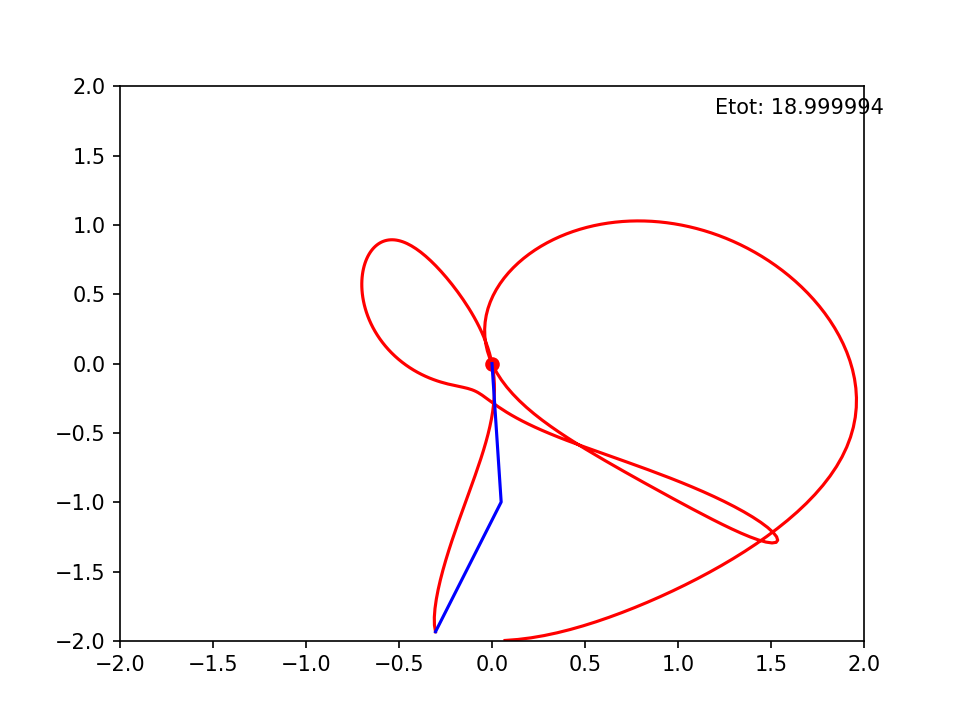

In [11]:
fig, ax = plt.subplots()
## arm lengths
R1 = 1.0
R2 = 1.0

cent = plt.plot([0.0], [0.0], 'ro')
ax.set_xlim(-(R1+R2), R1+R2)
ax.set_ylim(-(R1+R2), R1+R2)
tr, = plt.plot([0], [0], 'r-')

## set up arm initial state
## [theta1, theta2, theta1', theta2']
TS = [0.0, 0.0, 7.0, 0.0]
TSA = [TS] ## array of states
Tl = 1000 ## number of previous points to plot

def armvecx(TS):
    return [0.0, R1*np.sin(TS[0]), R1*np.sin(TS[0])+R2*np.sin(TS[1])]
def armvecy(TS):
    return [0.0, -R1*np.cos(TS[0]), -R1*np.cos(TS[0])-R2*np.cos(TS[1])]

arm, = plt.plot(armvecx(TS), armvecy(TS), 'b')
etot = plt.text(0.6*(R1+R2), 0.9*(R1+R2), 'Etot: ')

dt = 100/10000 #making this step size smaller will slow the energy increase

def init():
    arm.set_xdata( armvecx(TSA[-1]) )
    arm.set_ydata( armvecy(TSA[-1]) )
    tr.set_xdata(0)
    tr.set_ydata(0)
    return arm, tr,

recx = []
recy = []

def animate(i):
    ## asking the ODE code to do just one step
    #def theODE(TH, t, r1, r2, m1, m2, k1, k2, g):

    SOL = odeint(theODE, TSA[-1], [0.0, dt], args=(R1, R2, 1.0, 1.0, 0.0, 0.0, 10.0))
    TSA.append(SOL[-1])
    arm.set_xdata( armvecx(TSA[-1]) )
    arm.set_ydata( armvecy(TSA[-1]) )
    etot.set_text("Etot: %6.6f" % Etot(R1, R2, 1.0, 1.0, 0.0, 0.0, \
                                      TSA[-1][0], TSA[-1][1], TSA[-1][2], TSA[-1][3], 10.0 ))
    recx.append(armvecx(TSA[-1])[2])
    recy.append(armvecy(TSA[-1])[2])
    tr.set_xdata(recx)
    tr.set_ydata(recy)
    return arm, tr,
    

## interval is ms delay between frames
animate(0)
ani = animation.FuncAnimation( fig, animate, init_func=init, interval=100,\
                               blit=True )

plt.show()